In [14]:
import os
import sys
import gzip
import shutil
import re
import json

if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import numpy as np
import sumolib
import pandas as pd

sys.path.append(os.path.abspath("../src"))
from sim import sumo_utils
from sim import sumo_helper
from sim import llama_connect

FOLDER_NAME = "../src/sumo_map/Town01" # Path to SUMO map folder
mapname = FOLDER_NAME.split('/')[-1] # Extracting the map name from the folder name

### Defining paths and setting up osm.sumocfg file

In [15]:
NET_PATH = f'{FOLDER_NAME}/{mapname}.net.xml'
SUMOCFG_PATH = f'{FOLDER_NAME}/osm.sumocfg'
PA_PATH = f'{FOLDER_NAME}/park.add.xml' 
PA_REROUTER_PATH = f'{FOLDER_NAME}/pa_rerouter.xml'

sumo_helper.add_xml_child(SUMOCFG_PATH, 'input', 'net-file', f'{mapname}.net.xml')

# Setting up time to teleport as 
# -1 (never teleport): Vehicles will never teleport, but this could cause deadlock.
# >0 (seconds): Vehicles will teleport after the specified time if they are not able to reach their destination.
time_to_teleport = 100
sumo_helper.add_xml_child(SUMOCFG_PATH, 'processing', 'time-to-teleport', f'{time_to_teleport}')

# Adding lateral resolution to use SubLane model
lateral_resolution = 0.8
sumo_helper.add_xml_child(SUMOCFG_PATH, 'parameters', 'lateral-resolution', f'{lateral_resolution}')

# Setting up the timestep (default is 1 second), this does not affect the simulation speed but the resolution of the simulation. A smaller timestep will result in a more accurate simulation
step_length = 0.1
sumo_helper.add_xml_child(SUMOCFG_PATH, 'time', 'step-length', f'{step_length}')

# Setting up the simulation duration. To simulate 24 hours, we set the end time to (3600 steps * 24 hours) / step_lenght.
end_time = ''
sumo_helper.add_xml_child(SUMOCFG_PATH, 'time', 'end', f'{end_time}')

if not os.path.exists(NET_PATH):
    gz_path = f"{FOLDER_NAME}/osm.net.xml.gz"
    if os.path.exists(gz_path):
        with gzip.open(gz_path, 'rb') as f_in:
            with open(NET_PATH, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Extracted {gz_path} to {NET_PATH}")
    else:
        raise FileNotFoundError(f"{gz_path} does not exist.")
    
net = sumolib.net.readNet(NET_PATH)
net_offset = net.getLocationOffset() # Necessary to convert from CARLA to SUMO coordinates if needed

Child <net-file> with value 'Town01.net.xml' already exists. Skipping addition.
Child <time-to-teleport> with value '100' already exists. Skipping addition.
Child <lateral-resolution> with value '0.8' already exists. Skipping addition.
Child <step-length> with value '0.1' already exists. Skipping addition.
Child <end> with value '' already exists. Skipping addition.


# CARLA Routines

This section aims at creating rotines from routes given by CARLA

Here we are loading the interest points we collected in CARLA simulator.

In [16]:
routine_points = sumo_helper.get_spawn_points_from_csv(f'{FOLDER_NAME}/interest_points.csv')
carla_routine_coords = sumo_utils.get_coords_from_spawnpoints(routine_points, net_offset)
carla_routine_coords
sumo_utils.draw_debug_points(carla_routine_coords, output_path=f'{FOLDER_NAME}/debug.add.xml', size=5) # Write debug points to file to visualize in the spawn points in SUMO

Here we are loading the routines we obtained using the LLM. They are the routines generated by the carla simulator and are stored at `src/sim`.

In [17]:
routines = sumo_helper.get_routines_from_csv(f'../src/sim/llm_routines/{mapname}')
routines[0]

{'7': {'location': 'home', 'activity': 'wake up'},
 '8': {'location': 'school', 'activity': 'drop off kids'},
 '9': {'location': 'cafe', 'activity': 'breakfast'},
 '10': {'location': 'gym', 'activity': 'morning workout'},
 '11': {'location': 'school', 'activity': 'meet with friend'},
 '12': {'location': 'restaurant', 'activity': 'lunch meetup'},
 '13': {'location': 'work', 'activity': 'meetings'},
 '14': {'location': 'gym', 'activity': 'afternoon workout'},
 '15': {'location': 'university', 'activity': 'lectures'},
 '16': {'location': 'cafe', 'activity': 'snack break'},
 '17': {'location': 'bar', 'activity': 'social hour'},
 '18': {'location': 'theater', 'activity': 'evening show'},
 '19': {'location': 'school', 'activity': 'pick up kids'},
 '20': {'location': 'home', 'activity': 'spend time with family'},
 '21': {'location': 'cafe', 'activity': 'wind down'},
 '22': {'location': 'gym', 'activity': 'evening workout'},
 '23': {'location': 'home', 'activity': 'sleep'}}

From each routine, we transform it into coords of a SUMO trip

In [18]:
# This is the location time list from the routine generated in CARLA
location_time_list_carla = []
routine_ids_carla = []

for i in range(len(routines)):
    routine_ids_carla.append(f"veh{i}")
    location_time_list_carla.append(sumo_utils.coords_to_trip(routines[i], carla_routine_coords))

location_time_list_carla[0]

{7: {'location': 'home',
  'coords': (301.42999969482423, 158.1400018310547),
  'name': 'home'},
 8: {'location': 'school',
  'coords': (-1.9299780273437364, 364.759951171875),
  'name': 'school'},
 9: {'location': 'cafe',
  'coords': (199.120009765625, 271.1000085449219),
  'name': 'cafe'},
 10: {'location': 'gym',
  'coords': (1.6399987792968886, 232.25998168945313),
  'name': 'gym'},
 11: {'location': 'school',
  'coords': (-1.9299780273437364, 364.759951171875),
  'name': 'school'},
 12: {'location': 'restaurant',
  'coords': (129.85082946777345, 222.5578485107422),
  'name': 'restaurant'},
 13: {'location': 'work',
  'coords': (272.77003036499025, 288.29748779296875),
  'name': 'work'},
 14: {'location': 'gym',
  'coords': (1.6399987792968886, 232.25998168945313),
  'name': 'gym'},
 15: {'location': 'university',
  'coords': (272.7699998474121, 299.4599938964844),
  'name': 'university'},
 16: {'location': 'cafe',
  'coords': (199.120009765625, 271.1000085449219),
  'name': 'cafe'

In [19]:
location_time_list = location_time_list_carla
routine_ids = routine_ids_carla

## Driver Behavior Parameters

### Using LLM

Now we will generate the parameters for each style. The csv file `DriverBehParameters` must contain the relevant parameters, ranges and descriptions.

In [26]:
styles = ["normal", "aggressive"] # Description of the styles of the vehicles that are going to be generated
if os.path.exists('../configs/sumo_llm.json'):
    print("Loading existing parameter dictionary from sumo_llm.json")
    with open('../configs/sumo_llm.json', 'r') as f:
        vehdists = json.load(f)
    with open('../configs/sumo_dists_llm.json', 'r') as f:
        param_dict_llm = json.load(f)
else:
    data = pd.read_csv('../src/sim/sumoDriverBehParameters.csv')
    params = llama_connect.csv_str(data) # Turns the csv file into a string that can be passed to the LLM

    param_dict_llm = llama_connect.get_range_parameters(data, params, styles) # Generates the parameters for the vehicles
    llama_connect.verify_parameters(param_dict_llm, styles, separate_distributions=True)

    n_vtypes = 2 # Number of vehicles with varied parameters for each style
    vehdists = sumo_utils.generate_vehicle_types(param_dict_llm, styles, n_vtypes) # Generates the vehicle types for the vehicles

    # Write the parameter dictionary to a file
    with open(f"../configs/sumo_llm.json", "w") as f:
        json.dump(vehdists, f, indent=2)
    with open(f"../configs/sumo_dists_llm.json", "w") as f:
        json.dump(param_dict_llm, f, indent=2)

Loading existing parameter dictionary from sumo_llm.json


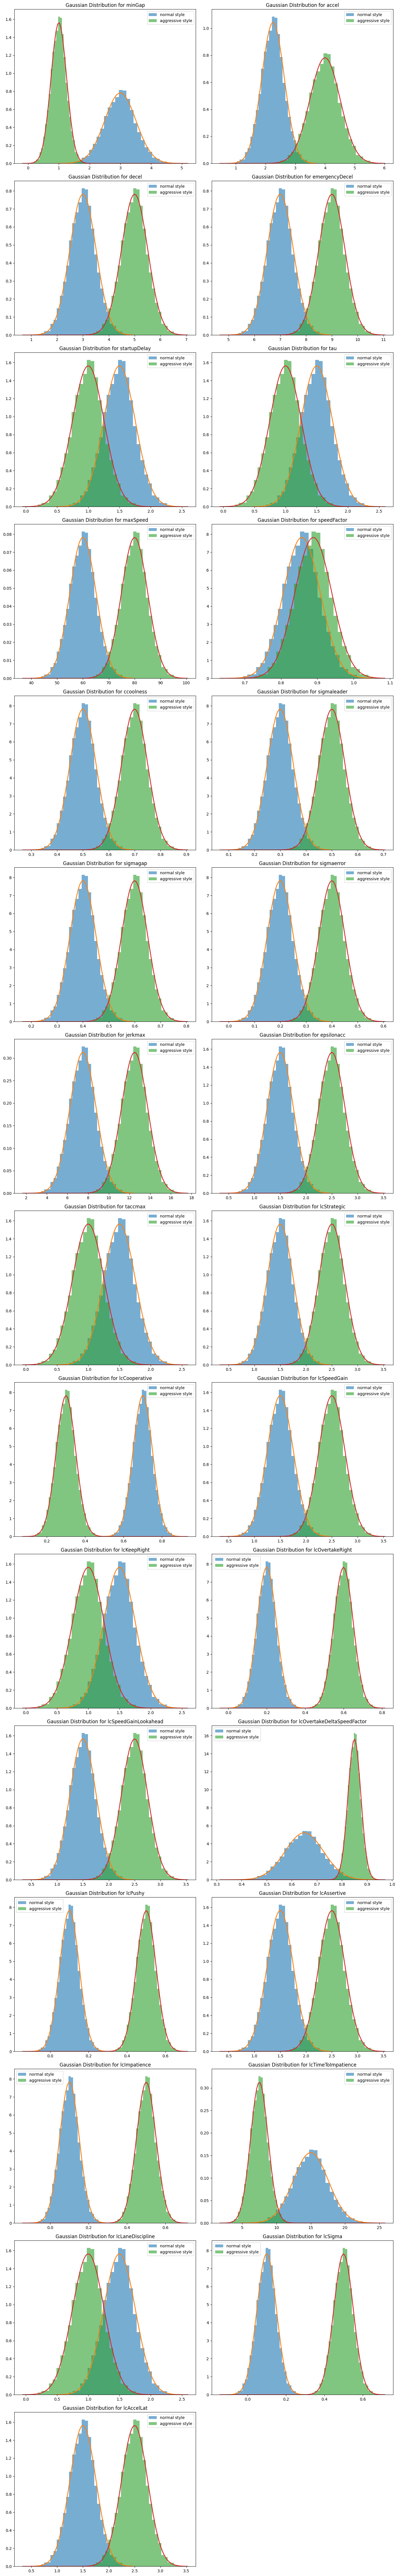

In [27]:
# Plot the distribution of the parameters for verification
llama_connect.show_gaussians(param_dict_llm, [data['Parameter'][i] for i in range(len(data['Parameter']))], styles) 

Now we create the distributions files vTypesDistribution.xml containing n_vtypes possible parameters for a given driving style. Here we define the car-following model and the lane-chaning model of the vehicles as well

In [28]:

v_types_file_llm = f'{FOLDER_NAME}/vTypesDistribution_LLM.xml'
sumo_helper.parse_veh_dist_xml(param_dict_llm, vehdists, styles, output_path=v_types_file_llm, car_follow_model="EIDM", lc_model="SL2015") # Parses the vehicles to the XML format and writes it to vTypesDistribution.xml
vtype_data_llm = sumo_helper.extract_vtype_distribution(v_types_file_llm)
vtype_data_llm

{'normal': ['veh_normal0', 'veh_normal1'],
 'aggressive': ['veh_aggressive0', 'veh_aggressive1']}

Defining the veh_style for each routine driver and creating the XML file for them, this will be written to **finaltrips_llm.rou.xml** and this file can be used directly as a route file for SUMO if there is no need to generate random trips.

In [30]:
# Merging the trips generated by the LLM with the random trips
final_trips_file_name = "finaltrips_llm.rou.xml"

final_trips_llm_path = f'{FOLDER_NAME}/{final_trips_file_name}'
v_types_file = v_types_file_llm # Here you can choose to use the LLM generated vehicle types or the fixed ones

# Defining the vehicle styles for the trips
veh_styles = []
for i in range(len(vtype_data_llm.keys())):
    if i % 2:
        # If the index is odd, use the random trip id
        veh_styles.append(np.random.choice(vtype_data_llm['normal'])) # Randomly choose a vehicle type from the normal distribution
    else:
        veh_styles.append(np.random.choice(vtype_data_llm['aggressive'])) # Randomly choose a vehicle type from the normal distribution


steps_per_stop = 10 # Number of steps in an hour
departure_times = [0, 20]  # Departure times for the trips, should be adjusted as needed

os.remove(final_trips_llm_path) if os.path.exists(final_trips_llm_path) else None # Remove the final trips file if it exists

# Adding the trips to the final trips file, one trip for each style
veh_ids_llm = [] # List to store the vehicle IDs for the LLM generated trips
for i in range(len(location_time_list)):
    for j in range(len(veh_styles)):
        style = veh_styles[j]
        dep_time = departure_times[j]
        style_base = re.sub(r'\d+', '', style).split('_')[-1]  # Base style name without the numeric suffix
        veh_id = f"veh_{i}_{style_base}"
        veh_ids_llm.append(veh_id) 

        path, stop_durations = sumo_utils.get_path(location_time_list[i], net, steps_per_stop=steps_per_stop, use_carla_routine=True) # Get the path and stop durations for the trips
        sumo_helper.add_trip_xml(path, stop_durations, veh_id, style, dep_time, use_carla_routine=True, out_file_path=final_trips_llm_path)

sumo_helper.add_missing_vtypes(final_trips_llm_path, v_types_file, final_trips_llm_path) # Adds the missing vehicle types to the final trips file
sumo_helper.save_ids_styles_csv(veh_ids_llm, veh_styles, f'{FOLDER_NAME}/id_to_vtype_llm.csv') # Save the vehicle IDs and styles to a CSV file

Updated ROUTES_FILE saved as ../src/sumo_map/Town01/finaltrips_llm.rou.xml
Saved to ../src/sumo_map/Town01/id_to_vtype_llm.csv


### Using Fixed Parameters

In [31]:
styles = ["normal", "aggressive"]
param_dict_fixed = json.load(open('../configs/sumo_fixed.json', 'r')) # Load the fixed parameters from the JSON file

In [33]:
n_vtypes = 1 # Number of vehicles with varied parameters for each style
v_types_file_fixed = f'{FOLDER_NAME}/vTypesDistribution_Fixed.xml'
sumo_helper.parse_veh_fixed_xml(param_dict_fixed, styles, v_types_file_fixed, car_follow_model="EIDM", lc_model="SL2015") # Parses the vehicles to the XML format and writes it to vTypesDistribution.xml
vtype_data_fixed = sumo_helper.extract_vtype_distribution(v_types_file_fixed)
vtype_data_fixed

{'normal': ['veh_normal'], 'aggressive': ['veh_aggressive']}

Defining the veh_style for each routine driver and creating the XML file for them, this will be written to **finaltrips_fixed.rou.xml** and this file can be used directly as a route file for SUMO if there is no need to generate random trips.

In [34]:
# Merging the trips generated by the LLM with the random trips
final_trips_file_name = "finaltrips_fixed.rou.xml"

final_trips_fixed_path = f'{FOLDER_NAME}/{final_trips_file_name}'
v_types_file = v_types_file_fixed # Here you can choose to use the LLM generated vehicle types or the fixed ones

steps_per_stop = 10 # Number of steps in an hour
departure_times = [0, 20]  # Departure times for the trips, can be adjusted as needed

os.remove(final_trips_fixed_path) if os.path.exists(final_trips_fixed_path) else None # Remove the final trips file if it exists
veh_styles = [f'veh_{style}' for style in styles]  # Vehicle styles for the trips, one for each style

# Adding the trips to the final trips file, one trip for each style
veh_ids_fixed = []
for i in range(len(location_time_list)):
    path, stop_durations = sumo_utils.get_path(location_time_list[i], net, steps_per_stop=steps_per_stop, use_carla_routine=True) # Get the path and stop durations for the trips

    for style, dep_time in zip(veh_styles, departure_times):
        style_base = re.sub(r'\d+', '', style).split('_')[-1]  # Base style name without the numeric suffix
        veh_id = f"veh_{i}_{style_base}"
        veh_ids_fixed.append(veh_id)  # Collect vehicle IDs for later use
        sumo_helper.add_trip_xml(path, stop_durations, veh_id, style, dep_time, use_carla_routine=True, out_file_path=final_trips_fixed_path)

sumo_helper.add_missing_vtypes(final_trips_fixed_path, v_types_file, final_trips_fixed_path) # Adds the missing vehicle types to the final trips file
sumo_helper.save_ids_styles_csv(veh_ids_fixed, styles, f'{FOLDER_NAME}/id_to_vtype_fixed.csv') # Save the vehicle IDs and styles to a CSV file

Updated ROUTES_FILE saved as ../src/sumo_map/Town01/finaltrips_fixed.rou.xml
Saved to ../src/sumo_map/Town01/id_to_vtype_fixed.csv


### Creating Random Trips to fill the simulation

Now we generate random vehicles throughout the simulation that will depart at each departure_step. Notice that they will not be running during all the simulation. The result will be written to **randtrips.rou.xml** and this file can be used as a route-file for SUMO directly if only random trips are desired.

In [18]:
# Generates equally distributed random trips for each vehicle class
# The trips will be written to the file "randtrips.rou.xml" and the vehicle ids will be returned 
rand_trips_file_name = "randtrips.rou.xml"
rand_trips_path = f'{FOLDER_NAME}/{rand_trips_file_name}'
end_time = 2000 # Overwrite the end time to 2000 seconds, the average time of the routines
v_types_data = vtype_data_fixed # Here you can choose to use the LLM generated vehicle types or the fixed ones
v_types_file = v_types_file_fixed

random_trips_ids = sumo_utils.get_random_trips(NET_PATH, end_time, v_types_data, departure_step=10, output_file_path=f'{FOLDER_NAME}/{rand_trips_file_name}')
sumo_helper.add_missing_vtypes(rand_trips_path, v_types_file_fixed, rand_trips_path) # Adds the missing vehicle types to the random trips file
print(random_trips_ids)

Success.
Success.
Generated 200 vehicles.
Updated ROUTES_FILE saved as ../src/sumo_map/Town01/randtrips.rou.xml
{'normal': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'], 'aggressive': ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138

### Merging the trips and updating route files

Lastly, merging the file with the routines and the file with the random trips into the **merged_fixed.rou.xml** file and the **merged_llm.rou.xml** file.

In [19]:
merged_output_file_name = "merged_fixed.rou.xml"
merged_output_fixed_file_path = f'{FOLDER_NAME}/{merged_output_file_name}'
final_trips_path = final_trips_fixed_path

sumo_helper.make_output_file(merged_output_fixed_file_path, final_trips_file_path = final_trips_path, random_trips_file_path = rand_trips_path)

Output file created at ../src/sumo_map/Town01/merged_fixed.rou.xml


'../src/sumo_map/Town01/merged_fixed.rou.xml'

In [20]:
merged_output_file_name = "merged_llm.rou.xml"
merged_output_llm_file_path = f'{FOLDER_NAME}/{merged_output_file_name}'
final_trips_path = final_trips_llm_path

sumo_helper.make_output_file(merged_output_llm_file_path, final_trips_file_path = final_trips_path, random_trips_file_path = rand_trips_path)

Output file created at ../src/sumo_map/Town01/merged_llm.rou.xml


'../src/sumo_map/Town01/merged_llm.rou.xml'

## Updating sumocfg file

Changing the sumocfg file to use the new files created

In [21]:
# Changing sumocfg to use the new route file (any of the two files can be used, but we will use the merged file)
# This will later be updated when running the simulation. We are only updating it now to be able to run the simulation in SUMO-GUI, if wanted.
sumo_helper.add_xml_child(SUMOCFG_PATH, 'input', 'route-files', merged_output_file_name)

if os.path.exists(f'{FOLDER_NAME}/debug.add.xml'):
    sumo_helper.add_xml_child(SUMOCFG_PATH, 'input', 'additional-files', 'debug.add.xml', replace=False)

print("All done! The SUMO configuration file has been updated to use the new route file.")
print(f"You can now run the simulation inside the {FOLDER_NAME} folder using `sumo-gui osm.sumocfg` or generate the data using the Simulation Data section.")

Child <route-files> with value 'merged_llm.rou.xml' already exists. Skipping addition.
Child <additional-files> with value 'debug.add.xml' already exists. Skipping addition.
All done! The SUMO configuration file has been updated to use the new route file.
You can now run the simulation inside the ../src/sumo_map/Town01 folder using `sumo-gui osm.sumocfg` or generate the data using the Simulation Data section.


In [22]:
try:
    print("IDs for the vehicles that were generated with routines:")
    print(routine_ids)
except:
    print("No vehicles were generated with routines.")

try:
    print("IDs for the vehicles that were generated with random trips:")
    print(random_trips_ids)
except:
    print("No vehicles were generated with random trips.")

IDs for the vehicles that were generated with routines:
['veh0']
IDs for the vehicles that were generated with random trips:
{'normal': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'], 'aggressive': ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136'

In [23]:
# Save the routines of each vehicle in a CSV file
try:
    sumo_helper.save_routines_csv(location_time_list, veh_ids_llm, dir_path = f'{FOLDER_NAME}/routines', use_lat_lon = False)
except Exception as e:
    print(f"Error saving routines (were they generated?): \n{e}")

Route saved to: ../src/sumo_map/Town01/routines/veh_0_aggressive.csv


Now you can use the `0_generate_sumo_data` notebook to runs the simulations.